# Short Interpolation using Kriging

In [14]:
import numpy as np
import statistics as stat
import scipy
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import PrizmCalibration as cl # this module is missing dependencies
from gsm_data import GSMData, get_desired_frequencies
# from data_prep import DataPrep

# For reloading the module (useful for debugging)
import data
import data_prep
try:
    reload(data) # dependent module (imported in data_prep)
    reload(data_prep)
    from data_prep import DataPrep
except:
    from importlib import reload
    reload(data) # dependent module (imported in data_prep)
    reload(data_prep)
    from data_prep import DataPrep

from helper_functions import *
import data_utils as du

import copy

try:
    reload(test_short_interp)
    from test_short_interp import make_acf, make_acf_alt
except:
    import test_short_interp
    reload(test_short_interp)
    from test_short_interp import make_acf, make_acf_alt

from numpy.polynomial import polynomial as P

## Step 0: Load in data

In [60]:
# Flag the 'bad' spectra
# For a first pass I have to fetch the mask from DataPrep
year = '2021'
instrument = '100MHz'
channel = 'NS'

dataprep = DataPrep(instrument, channel, year)
save_mask = copy.deepcopy(dataprep.calib_mask_dict['short']) # save the mask

Returning default mask
Returning default mask


In [61]:
# Actually save the mask so I don't have to load it in every time anymore.
datadir = '../test_data/2021/100MHz/NS/'
np.save(datadir+'shortdata_2021_100MHz_NS_mask.npy',save_mask)

In [82]:
year = '2021'
instrument = '100MHz'
channel = 'EW'

datadir = '../test_data/'+year+'/'+instrument+'/'+channel+'/'

save_mask = np.load(datadir+'shortdata_'+year+'_'+instrument+'_'+channel+'_mask.npy')
dat=np.load(datadir+'shortdata_meas_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
lst=np.load(datadir+'shortlst_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
t=np.load(datadir+'shortsystime_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
# dat_nomask = np.load(datadir+'shortdata_meas_2021_100MHz_NS.npy')
# lst_nomask = np.load(datadir+'shortlst_2021_100MHz_NS.npy')
# t_nomask = np.load(datadir+'shortsystime_2021_100MHz_NS.npy')

In [83]:
freqarr, freqstep = np.linspace(0,250,4096,retstep=True) # Based on number of frequency channels of the antenna
minfreq = 30
maxfreq = 200
minfreqarg = int(minfreq/freqstep)
maxfreqarg = int(maxfreq/freqstep)

## Step 1: Compute the autocorrelation function (ACF)

For now (testing purposes) we restrict to:

- one frequency channel: 100 MHz

- one section of the time series

- one data point to interpolate

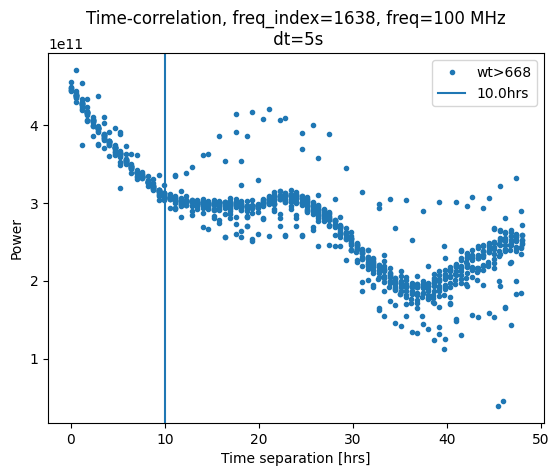

In [98]:
# tmax=1.6374e9
# tmin=1.6365e9
tmax=np.inf
tmin=0

mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]
ll=lst[mask]

''' Set frequency here'''
freq = 100 # MHz
freq_index = int(freq/freqstep)
'''-----------------------------'''

dt=5 # seconds
plt.clf()

# tot,wt=make_acf((dd[:,freq_index]-dd[:,freq_index].mean()),tt,dt=dt,tmax=2*86400)
tot2,wt2=make_acf_alt(dd[:,freq_index]-dd[:,freq_index].mean(),tt,dt=dt,tmax=2*86400)
# tot,wt=make_acf(dd-dd.mean(),tt,dt=dt,tmax=2*86400)
# tvec=np.arange(len(tot))*dt
tvec2=np.arange(len(tot2))*dt
# mm=wt>30
wt_crt = int(0.065*len(ll))
mm2=wt2>wt_crt
# print('tvec[wt>30]:',tvec[mm])
# print('tvec2[wt2>30]:',tvec2[mm2])

plt.plot(tvec2[mm2]/3600,(tot2[mm2]/wt2[mm2]),'.',label='wt>'+str(wt_crt))
# plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='i+1 version')

'''Set dtmax here -- i.e. the section of the ACF data used to fit a function'''
dtmax = 10*3600 # seconds
'''------------------------------------'''

plt.axvline(x=dtmax/3600,label=str(dtmax/3600)+'hrs')

plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')
plt.legend()
plt.show()

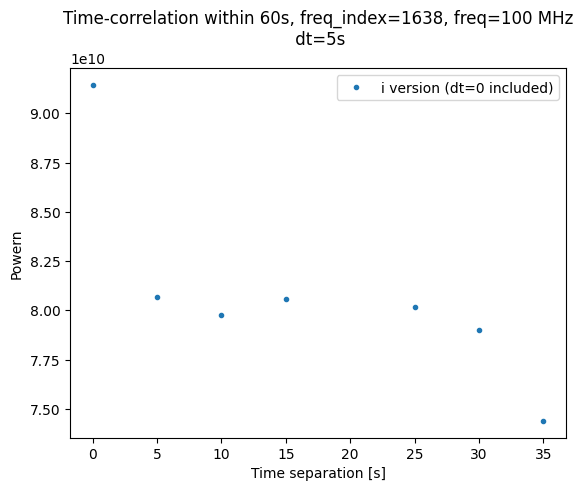

[ 0  5 10 15 25 30 35]


In [37]:
plt.plot(tvec2[mm2][tvec2[mm2]<60],(tot2[mm2]/wt2[mm2])[tvec2[mm2]<60],'.',label='i version (dt=0 included)')

plt.title('Time-correlation within 60s, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.ylabel('Powern')
plt.xlabel('Time separation [s]')
plt.legend()
plt.show()

print(tvec2[mm2][tvec2[mm2]<60])

In [100]:
print(np.min(np.diff(tt)))

5.275755882263184


1.3333333333333333 mins
2
(86,)
(86,)


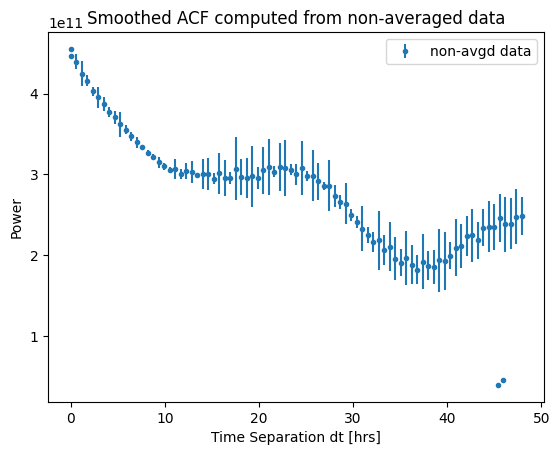

In [88]:
'''Smoothing the ACF by binning, but keeping the dt=0 bin/peak intact! -- NON AVERAGED DATA'''
# Separate the current dt values into bins within a few minutes of each other, I think this normally corresponds to data taken during the same rotation through calibrators before going back to antenna

# binwidth = 60*5 # 5 minute bins, 5*60 seconds time difference to be considered in the same bin

# Example array of time values in seconds (with large time gaps)
time_values = tvec2[mm2][1:]
acf_values = (tot2[mm2]/wt2[mm2])[1:]
zerobin = (tot2[mm2]/wt2[mm2])[0] # save the zero-bin
tsteps = np.diff(time_values)

# Define bin size (5 minutes = 5x60 seconds)
bin_size = 60*5

# Create bin edges based on big jumps in the timestep between subsequent measurements
bins = np.where(tsteps>5*60)[0]
# print(bins)

# Split 
bin_tgroups = np.split(time_values,bins+1,axis=0)
bin_acf_groups = np.split(acf_values,bins+1,axis=0)

t_binavg = []
acf_binavg = []
acf_binstd = []
largest_binwidth = 0

for i in range(len(bin_tgroups)):
    t_binavg.append(np.mean(bin_tgroups[i]))
    acf_binavg.append(np.mean(bin_acf_groups[i]))
    acf_binstd.append(np.std(bin_acf_groups[i]))
    if (bin_tgroups[i][-1]-bin_tgroups[i][0]) > 5*60:
        print('bin larger than 5 minutes:',bin_tgroups[i][-1]-bin_tgroups[i][0])
    if (bin_tgroups[i][-1]-bin_tgroups[i][0] > largest_binwidth):
        largest_binwidth = bin_tgroups[i][-1]-bin_tgroups[i][0]
        largest_bini = i

print(largest_binwidth/60,'mins')
print(largest_bini)

# Print the results
smoothed_times = np.concatenate(([0],t_binavg))
smoothed_acf = np.concatenate(([zerobin],acf_binavg))
smoothed_std = np.concatenate(([0],acf_binstd))
print(smoothed_std.shape)
print(smoothed_acf.shape)
# print("Average time for non-empty bins:", smoothed_times)
# print("Average acf value for non-empty bins:", smoothed_acf)

plt.errorbar(x=smoothed_times[smoothed_times<50*3600]/3600,y=smoothed_acf[smoothed_times<50*3600],yerr=smoothed_std[smoothed_times<50*3600],marker='.',ls='None',label='non-avgd data')
# plt.plot(smoothed_times/3600,smoothed_acf,'.')

plt.legend()
plt.title('Smoothed ACF computed from non-averaged data')
plt.xlabel('Time Separation dt [hrs]')
plt.ylabel('Power')

plt.show()

In [29]:
print(bin_tgroups[20]-bin_tgroups[20][0])
print(bin_tgroups[21]-bin_tgroups[20][0])

[ 0  5 10 15 20 25 30 35 45 50 55 60 65 70 75]
[2105 2110 2115 2120 2125 2130 2135 2140 2145 2150 2155 2165 2170 2175]


Since the autocorrelation function still looks a little weird, we will only focus use the dt = 0 to dt = 8h section.

Also we plot the data:

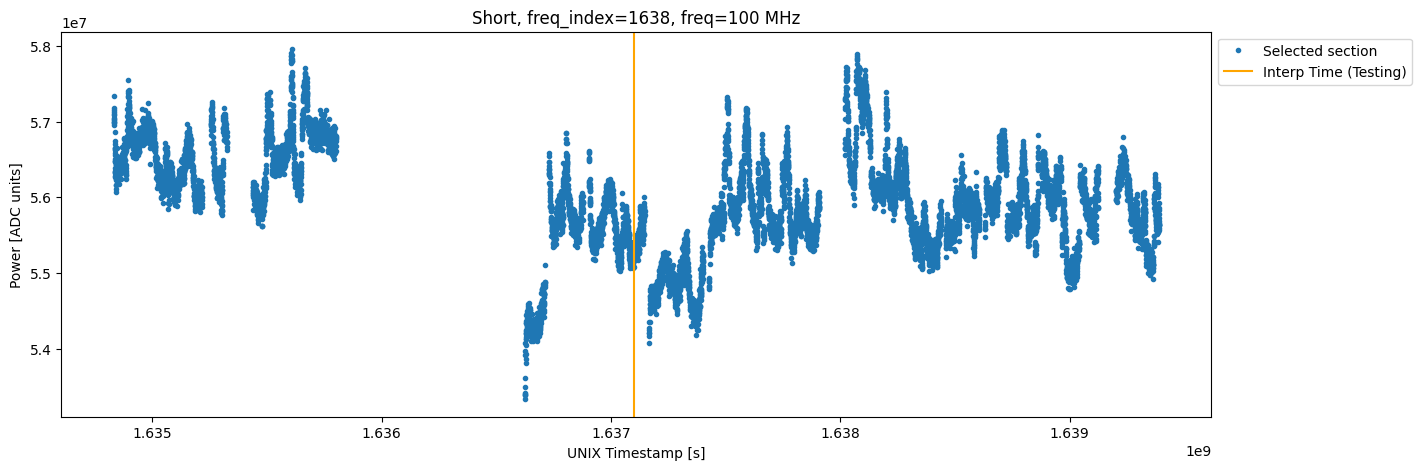

In [65]:
# vs UNIX timestamp

''' Set interp_time here'''
interp_time = 1.6371e9
'''--------------------'''

plt.figure(figsize=(20,5))
# plt.plot(t,dat[:,freq_index],'.',label='All times')
plt.plot(tt,dd[:,freq_index],'.',label='Selected section')
plt.axvline(x=interp_time,label='Interp Time (Testing)',color='orange') 
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('Power [ADC units]')
plt.title('Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.show()

# Step 2: Fit the autocorrelation function

In [89]:
# As a simple first pass for just the 0 to 8h section of the ACF we 
def linfunc(x,a,b):
    return a*x+b

def expfunc(x,a,b):
    return a*np.exp(-x/b)

# def expabsfunc(x,a,b):
#     return a*np.exp(-b*abs(x))

def ACF_fit(a,b,functype='linear'):
    if functype == 'linear':
        return lambda dt: a*dt+b
    elif functype == 'exponential':
        return lambda dt: a*np.exp(-dt/b)

def ACF_wgn(dt):
    if dt == 0: return np.random.normal(loc=1,scale=0.03,size=1)
    else: return np.random.normal(loc=0,scale=0.03,size=1)

[2.69194594e+07 2.36412583e+08 3.38565320e+08]


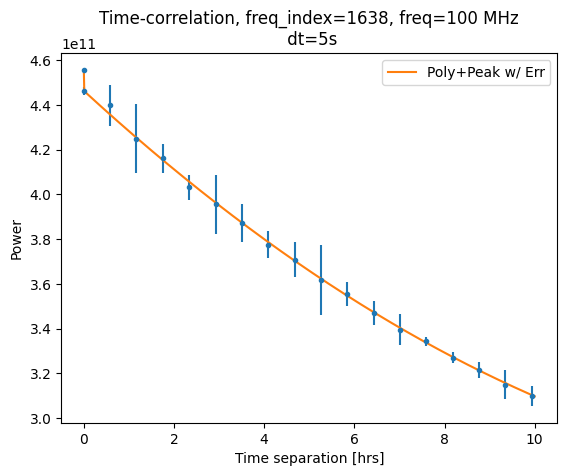

In [90]:
# plt.plot(tvec2[mm2][tvec2[mm2]<dtmax]/3600,(tot2[mm2]/wt2[mm2])[tvec2[mm2]<dtmax],'.',label='ACF Data, with dt=0 bin')
# plt.plot(tvec[mm][tvec[mm]<dtmax]/3600,(tot[mm]/wt[mm])[tvec[mm]<dtmax],'.',label='ACF Data, no dt=0 bin')
# plt.plot(smoothed_times[smoothed_times<10*3600]/3600,smoothed_acf[smoothed_times<10*3600],'.')
plt.errorbar(x=smoothed_times[smoothed_times<10*3600]/3600,y=smoothed_acf[smoothed_times<10*3600],yerr=smoothed_std[smoothed_times<10*3600],marker='.',ls='None')

tfitvec = np.linspace(0,dtmax/3600,1000)

# Do the fit:

# ------------ parabola from 0< to 10, add peak height at dt=0
# c, cov = np.polyfit(x=smoothed_times[(0<smoothed_times)&(smoothed_times<10*3600)]/3600,y=smoothed_acf[(0<smoothed_times)&(smoothed_times<10*3600)],deg=2,cov=True)
# polyfunc = np.poly1d(c)
# print(np.diag(cov)**(1/2))

c_errs, coverrs = np.polyfit(x=smoothed_times[(0<smoothed_times)&(smoothed_times<10*3600)]/3600,y=smoothed_acf[(0<smoothed_times)&(smoothed_times<10*3600)],
                    w=1/smoothed_std[(0<smoothed_times)&(smoothed_times<10*3600)],deg=2,cov=True)
polyfunc_witherrs = np.poly1d(c_errs)
print(np.diag(coverrs)**(1/2))

zeropeak_height = abs(smoothed_acf[0] - smoothed_acf[1])

def delta_function(x, location=0, amplitude=zeropeak_height, width=1):
    delta = np.zeros_like(x)
    # Step 3: Add a sharp peak at the specified location
    idx = np.argmin(np.abs(x - location))  # Find the index closest to the location
    if x[idx] == location:
        # we only want the peak at exactly zero
        delta[idx:idx+width] = amplitude  # Set the value to amplitude (height of delta peak)
    return delta

def ACF_func(dt):
    return polyfunc_witherrs(dt) + delta_function(dt,amplitude=zeropeak_height)

plt.plot(tfitvec,ACF_func(tfitvec),label='Poly+Peak w/ Err')
# ---------------------------------------------------

# ------------ exp or linear

# popt2, pcov2 = scipy.optimize.curve_fit(f=linfunc,xdata=smoothed_times[smoothed_times<dtmax]/3600,ydata=smoothed_acf[smoothed_times<dtmax],p0=[-6e10/8,9.1e10])
# plt.plot(tfitvec,linfunc(tfitvec,popt2[0],popt2[1]),label='Linear Fit, with dt=0 bin')
# popt2, pcov2 = scipy.optimize.curve_fit(f=expfunc,xdata=smoothed_times[smoothed_times<dtmax]/3600,ydata=smoothed_acf[smoothed_times<dtmax],p0=[9.1e10,4])
# plt.plot(tfitvec,expfunc(tfitvec,popt2[0],popt2[1]),label='Exp Fit')
# # popt, pcov = scipy.optimize.curve_fit(f=expabsfunc,xdata=tvec[mm][tvec[mm]<dtmax]/3600,ydata=(tot[mm]/wt[mm])[tvec[mm]<dtmax],p0=[9.1e10,4])
# # plt.plot(tfitvec,expabsfunc(tfitvec,popt[0],popt[1]),label='Exp Fit')

# print(popt)
# print(popt2)
# ACF_func = ACF_fit(popt2[0],popt2[1],functype='linear') # currently using version with dt=0 included

# ------------------------------------------


# ---------------- using np.polyfit
# c = np.polyfit(x=smoothed_times[smoothed_times<dtmax]/3600,y=smoothed_acf[smoothed_times<dtmax],deg=4)
# ACF_func = np.poly1d(c)
# plt.plot(tfitvec,ACF_func(tfitvec),label='Poly')
# ----------------------------------------------


plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')
plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.legend()
plt.show()

## Step 3: Build the covariance matrix

In [91]:
# "d": the data array, for convenience we put the point where we want to interpolate (marked by a 0) at the end 
# of the array of existing data

# "C": the covariance matrix of data d
'''Making a matrix with only the data within 8h of the interp time'''
# I had to reduce to 8h total (4h around interp time) interval so there's no need to use the ACF at dt > 8h
d_red = dd[abs(tt - interp_time) < dtmax/2,freq_index] 
t_red = tt[abs(tt - interp_time) < dtmax/2]
d = np.append(d_red,0)
tarr = np.append(t_red,interp_time)
C = np.zeros(shape=(len(d),len(d))) # initialize
'''--------------------------------------'''
# d = np.append(dd_gauss,0) # append 0 to end of data array
# d = np.append(dd,0)
# tarr = np.append(t_gauss,interp_time) # append the time where we want to generate an interpolated point
# C = np.zeros(shape=(len(d),len(d))) # initialize

# for i in range(len(d)):
#     for j in range(len(d)):
#         dtij = abs(tarr[i]-tarr[j]) # time separation between points
        
#         if dtij > dtmax:
#             # For now, we are only using the ACF up to dt = 8 hours. If dtij > 8h, set C_ij = 0 (uncorrelated).
# #             print('larger')
# #             print(dtij)
#             C[i,j] = 0
#             print('larger') # normally this should not happen since we've already truncated the array
#         else:
            
#             C[i,j] = ACF_func(dtij/3600) # ACF_func is defined for dt in hours

# Vectorizing the second loop:

for i in range(len(d)):
    ti = tarr[i]
    dtij_arr = abs(ti-tarr) # full array of the time separation from ti
    if np.any(dtij_arr>dtmax): print('larger') # normally this should not happen since we've already truncated the array
    
    C[i,:] = ACF_func(dtij_arr/3600) # ACF_func is defined for dt in hours
    

''' Add a large constant to the covariance matrix to mitigate the non-zero mean issue'''
C += 1e14

## Step 4: Invert the covariance matrix

In [92]:
Cinv = np.linalg.inv(C)
# print(Cinv@C)

# U, Sdiag, VT = np.linalg.svd(C, full_matrices=False) # SVD
# Cinv_svd = VT.T @ np.diag(1/Sdiag) @ U.T
# print(Cinv_svd@C)

# lam, Q = scipy.linalg.eig(C) # eigenvector/value
# lam = np.real(lam)
# Q = np.real(Q)
# # print(lam)
# Cinv_eig = Q @ np.diag(1/lam) @ np.linalg.inv(Q)
# print(Cinv_eig@C)

# print(Cinv_svd.shape)
# print(Cinv.shape)
# print(Cinv_eig.shape)
# print(np.sum(abs(Cinv-Cinv_svd)))
# print(np.sum(abs(Cinv-Cinv_eig)))

## Step 5: Compute the weights for each data point

The interpolated value consists of a weighted sum of existing data, where the weights are given by:

$$ w[1..n]= \frac{-C^{-1}[n+1,1..n]}{C^{-1}[n+1][n+1]} $$

where $n$ is the number of measured data points, and $n+1$ is due to adding the new interpolated point to the end of the data array.

In [93]:
# "w": array of weights for the weighted sum to compute inteprolated value
n = len(d)-1
w = -Cinv[n,0:n] / Cinv[n,n]

## Step 6: Compute the weighted sum

In [94]:
dinterp = np.dot(w,d[0:n])
print(dinterp)
interp_err = np.sqrt(1/Cinv[n,n])
print(interp_err)
A = np.zeros(len(d))
A[n] = -1
interp_err = np.sqrt(1/(A.T@Cinv@A)) # just to verify it's the same thing
print(interp_err)

55235700.304880045
108363.32010746459
108363.32010746459


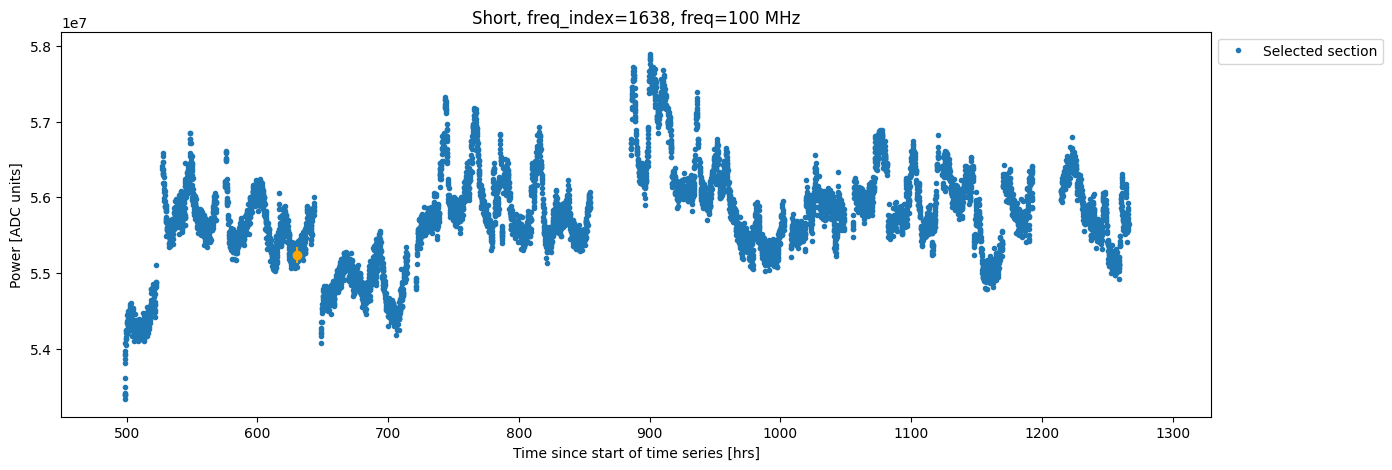

In [95]:
# Let's plot the result

plt.figure(figsize=(20,5))
plt.plot((tt-tt[0])/3600,dd[:,freq_index],'.',label='Selected section',zorder=0)
# plt.axvline(x=(interp_time-tt[0])/3600,label='Interp Time (Testing)',color='orange',zorder=1) 
plt.errorbar(x=(interp_time-tt[0])/3600,y=dinterp,yerr=interp_err,color='orange',marker='o')
plt.xlabel('Time since start of time series [hrs]')
plt.ylabel('Power [ADC units]')
plt.title('Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.xlim(left=450)
plt.show()

Hmmmm ok this does not look good.
Try plotting the weights to make sure it works?
Maybe the problem is with the proper inversion of the C matrix. Look into matrix decomposition tricks from phys 512.

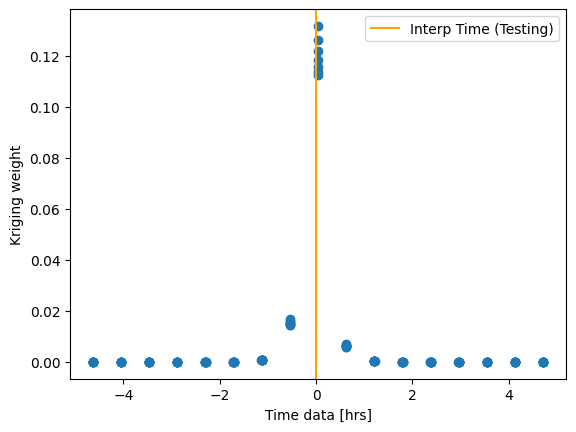

In [96]:
# plt.scatter(tt[abs(w)<100],w[abs(w)<100])
plt.scatter((t_red-interp_time)/3600,w)
plt.axvline(x=(interp_time-interp_time)/3600,label='Interp Time (Testing)',color='orange') 
plt.xlabel('Time data [hrs]')
plt.ylabel('Kriging weight')
plt.legend()
plt.show()

# why does this look like zero sometimes  and random other times????
# tt[w>200]